In [87]:
using IntervalArithmetic
using Plots 
using Dates
using StatsBase

## Common functions

In [2]:
function phi_n(phi,T,x, s, n)
    "Calculate the image of phi^{(n)}"
    if n == 0
        return s
    else
        return phi.image(x, phi_n(phi,T,T.image(x), s, n-1))
    end
end


phi_n (generic function with 1 method)

In [3]:
function phi_nBoundK(phi,T,x, s, n,K)
    if n == 0
        return s
    else
        return phi.image(x,min(phi_nBoundK(phi,T,T.image(x), s, n-1,K),K))
    end
end

phi_nBoundK (generic function with 1 method)

In [4]:
function compose(f, x, n)
    if n == 0
        return x
    else
        return compose(f, f(x), n-1)
    end
end


compose (generic function with 1 method)

## Upper bound of q

In [5]:
function FindNK(phi,T,N) 
    "Find N such that the derivative at 1 of phi is always bigger than 1"
    x=[interval((i-1)/2^N,i/2^N) for i in 1:2^N]
    y=[phi.exp(u) for u in x]
    infi=minimum([inf(z) for z in y])
    NK=1
    while infi <= 1 && NK<30
        NK=NK+1
        x=[T.image(i) for i in x]
        y=y.*[phi.exp(u) for u in x]
        infi=minimum([inf(z) for z in y])
    end
    if NK==30
        error("NK not find")
    end
    return NK
end


FindNK (generic function with 1 method)

In [6]:
function FindNKv2(phi,T,N)
    K=Inf
    x=[interval((i-1)/2^N,i/2^N) for i in 1:2^N]
    y=[phi.exp(u) for u in x]
    for NK in 1:8
        infi=minimum([inf(z) for z in y])
        if infi>1
            K=min(K,FindKv2(phi,T,NK,N))
        end
        x=[T.image(i) for i in x]
        y=y.*[phi.exp(u) for u in x]
    end
    if K==Inf
        error("NK not find")
    end
    return K
end

FindNKv2 (generic function with 1 method)

In [7]:
function FindK(phi,T,NK,N)
    "Find K which dominates the extinction probability"
    K=1/2
    A=[interval((i-1)/2^N,i/2^N) for i in 1:2^N]
    while any(K-sup(phi_n(phi,T,x, K, NK))< 0 for x in A) && K<0.9999
        K=(1+K)/2
    end
    if K>=0.9999
        return error("NK not find")
    end
    return maximum([sup(phi_n(phi,T,x, K, NK)) for x in A])
end 


FindK (generic function with 1 method)

In [8]:
function FindKv2(phi,T,NK,N)
    "Find K which dominates the extinction probability"
    K=1/2
    A=[interval((i-1)/2^N,i/2^N) for i in 1:2^N]
    while any(K-sup(phi_n(phi,T,x, K, NK))< 0 for x in A) && K<0.9999
        K=(1+K)/2
    end
    if K>=0.9999
        return K=Inf
    end
    return maximum([sup(phi_n(phi,T,x, K, NK)) for x in A])
end 

FindKv2 (generic function with 1 method)

In [9]:
function upboundq(phi,T,n,N,plt)  # N>n
    "find a good upper bound of q"
    NK=FindNK(phi,T,N)
    K=FindK(phi,T,NK,N)
    l1=[[interval(i/2^N,(i+1)/2^N),interval(K,K)]  for i in 0:(2^N-1)]
    l2=[phi_n(phi,T,x[1],x[2],n) for x in l1]
    if plt==true
        x=[i/2^N for i in 1:2^N]
        majqm=[sup(i) for i in l2]
        p=plot(x,majqm,title="upboundq",ylim=(-0.01,1.01))
        display(p)
    end
    return l2
end 


upboundq (generic function with 1 method)

## Upper bound of LambdaF

In [10]:
function upboundlambdaF(phi,T,n,N,m)
    "find a good upper bound of lambdaF method 1"   
    NK=FindNK(phi,T,N)
    K=FindK(phi,T,NK,N)
    l=[[interval(i/2^N,(i+1)/2^N) for i in 0:2^N-1]]
    for i in 1:m
        push!(l,[T.image(x) for x in l[i]])
    end
    l1=[[x,interval(K,K)]  for x in l[m+1]]
    majq=[phi_n(phi,T,x[1],x[2],n) for x in l1]
    r=[interval(0,0) for i in 1:2^N]
    for i in 1:m
        r+=[phi.logds(l[m+1-i][j],majq[j]) for j in 1:2^N]
        if i<m
            majq=[phi.image(l[m+1-i][j],majq[j]) for j in 1:2^N]
        end
    end
    return maximum([sup(j) for j in r])/m
end

upboundlambdaF (generic function with 1 method)

In [50]:
function upboundlambdaF2(phi,T,n,N,m)
    "find a good upper bound of lambdaF method 2"   
    NK=FindNK(phi,T,N)
    K=FindK(phi,T,NK,N)
    l=[interval(i/2^N,(i+1)/2^N) for i in 0:2^N-1]
    Tl=[]
    r=[interval(0,0) for i in 1:2^N]
    infi=[0 for i in 1:2^N]
    for i in 1:m
        Tl=[T.image(x) for x in l]
        majq=[phi_nBoundK(phi,T,x,interval(K,K),n,K) for x in Tl]
        r+=[phi.logds(l[j],majq[j]) for j in 1:2^N]
        infi=[min(sup(r[j])/i,infi[j]) for j in 1:2^N]
        l=Tl
    end
    return maximum(infi)
end

upboundlambdaF2 (generic function with 1 method)

In [138]:
function upboundlambdaF3(phi,T,n,N,m)
    "find a good upper bound of lambdaF method 3"   
    K=FindNKv2(phi,T,N)
    l=[interval(i/2^N,(i+1)/2^N) for i in 0:2^N-1]
    Tl=[]
    r=[interval(0,0) for i in 1:2^N]
    infi=[0 for i in 1:2^N]
    for i in 1:m
        Tl=[T.image(x) for x in l]
        majq=[phi_nBoundK(phi,T,x,interval(K,K),n,K) for x in Tl]
        r+=[phi.logds(l[j],majq[j]) for j in 1:2^N]
        infi=[min(sup(r[j])/i,infi[j]) for j in 1:2^N]
        l=Tl
    end
    return maximum(infi)
end

upboundlambdaF3 (generic function with 1 method)

In [143]:
upboundlambdaF3(phi1(0.7),T1(0),14,16,8)


-0.15179372255457313

In [136]:
function upboundlambdaNew(phi,T,n,N,m)
    K=FindNKv2(phi,T,N)
    l=[interval(i/2^N,(i+1)/2^N) for i in 0:2^N-1]
    Tl=[]
    r=[interval(0,0) for i in 1:2^N]
    infi=[0 for i in 1:2^N]
    for i in 1:m
        Tl=[T.image(x) for x in l]
        majq=[phi_nBoundK(phi,T,x,interval(K,K),n,K) for x in Tl]
        r+=[phi.logds(l[j],majq[j]) for j in 1:2^N]
        infi=[min(sup(r[j])/i,infi[j]) for j in 1:2^N]
        l=Tl
    end
    K=FindNKv2(phi,T,N+2)
    bound=quantile(infi,0.75)
    Indice=(findall(x -> x > bound, infi).-1).*4
    IndiceNew=vcat(Indice,Indice.+1,Indice.+2,Indice.+3)
    len=length(IndiceNew)
    l=[interval(i/2^(N+2),(i+1)/2^(N+2)) for i in IndiceNew]
    Tl=[]
    r=[interval(0,0) for i in 1:len]
    infi=[0 for i in 1:len]
    for i in 1:m
        Tl=[T.image(x) for x in l]
        majq=[phi_nBoundK(phi,T,x,interval(K,K),n,K) for x in Tl]
        r+=[phi.logds(l[j],majq[j]) for j in 1:len]
        infi=[min(sup(r[j])/i,infi[j]) for j in 1:len]
        l=Tl
    end
        return maximum(infi)
end

upboundlambdaNew (generic function with 1 method)

In [142]:
upboundlambdaNew(phi1(0.7),T1(0),14,14,8)

-0.15179372255457313

In [95]:
[i  for i in 1:3].*4

3-element Vector{Int64}:
  4
  8
 12

## Lower bound of q 

In [12]:
function lowboundq(phi,T,n,N,plt)  # N>n
    "find a good lower bound of q"
    l1=[[interval(i/2^N,(i+1)/2^N),interval(0,0)]  for i in 0:(2^N-1)]
    l2=[phi_n(phi,T,x[1],x[2],n) for x in l1]
    if plt==true
        x=[i/2^N for i in 1:2^N]
        minqm=[inf(i) for i in l2]
        p=plot(x,minqm,title="lowboundq",ylim=(-0.01,1.01))
        display(p)
    end
    return l2
end

lowboundq (generic function with 1 method)

## Bounds on q 

In [13]:
function boundq(phi,T,n,N,plt)  # N>n
    "find good bounds of q"
        NK=FindNK(phi,T,N)
        K=FindK(phi,T,NK,N)
        l1=[[interval(i/2^N,(i+1)/2^N),interval(K,K)]  for i in 0:(2^N-1)]
        l2=[phi_n(phi,T,x[1],x[2],n) for x in l1]
        l3=[[interval(i/2^N,(i+1)/2^N),interval(0,0)]  for i in 0:(2^N-1)]
        l4=[phi_n(phi,T,x[1],x[2],n) for x in l3]
        if plt==true
            x=[i/2^N for i in 1:2^N]
            majqm=[sup(i) for i in l2]
            minqm=[inf(i) for i in l4]
            plot(x,majqm,label="upboundq",ylim=(-0.01,1.01))
            display(plot!(x,minqm,label="lowboundq"))
        end
        return l2,l4
    end

boundq (generic function with 1 method)

## Lower bound of Lambda_F

In [14]:
"finds a representative of each sequence of size n with integer values 
between 0 and d up to rotation and not containing a repeating pattern"

function is_rotation_of_minimal(seq, n)
    for i in 1:n-1
        rotated_seq = vcat(seq[i+1:end], seq[1:i])
        if rotated_seq < seq
            return false
        end
    end
    return true
end

function has_repeating_pattern(seq, n)
    for len in 1:div(n, 2)
        if n % len == 0
            pattern = seq[1:len]
            is_repeating = true
            for i in 1:div(n, len)
                if seq[(i-1)*len+1:i*len] != pattern
                    is_repeating = false
                    break
                end
            end
            if is_repeating
                return true
            end
        end
    end
    return false
end

function generate_minimal_non_repeating_sequences(d::Int, n::Int)
    minimal_sequences = Vector{Vector{Int}}()  
    seq = fill(0, n)  
    
    while seq != nothing
        if is_rotation_of_minimal(seq, n) && !has_repeating_pattern(seq, n)
            push!(minimal_sequences, copy(seq))  # Ajouter une copie de la séquence à la liste
        end
        seq = next_sequence(seq, d)
    end
    
    return minimal_sequences
end

function next_sequence(seq::Vector{Int}, d::Int)
    n = length(seq)
    for i in n:-1:1
        if seq[i] < d - 1
            seq[i] += 1
            for j in i+1:n
                seq[j] = 0
            end
            return seq
        end
    end
    return nothing
end

next_sequence (generic function with 1 method)

In [15]:
function dichotomy(g,z,xm,XM,epsi)
    t=(xm+XM)/2
    while XM-xm>epsi
        if g(t)>z
            XM=t
        else
            xm=t
        end
        t=(xm+XM)/2
    end
    return t
end

dichotomy (generic function with 1 method)

In [16]:
function suite_dadique(suite::Vector{Int}, d::Int,i)
    value = [sum(suite[(j+i-k)%i+1] * d^(j-1) for j in 1:i) for k in 1:i]
    return value
end

suite_dadique (generic function with 1 method)

In [17]:
function logdphiq(phi,orbx,i,lbq,N,epsi)
    lf=0
    for j in 1:i
        qtx=orbx[(j%i)+1]
        indice=Int(mod(div(qtx,2.0^(-N)),2^N))
        if indice==0
            qtxE=hull(lbq[end],lbq[indice+1],lbq[indice+2])
        elseif indice==2^N-1
            qtxE=hull(lbq[indice],lbq[indice+1],lbq[1])
        else
            qtxE=hull(lbq[indice],lbq[indice+1],lbq[indice+2])
        end
        lf+=inf(phi.logds(interval(orbx[j]-epsi,orbx[j]+epsi),qtxE))
    end
    return lf/i
end

logdphiq (generic function with 1 method)

In [18]:
function lowboundlambdaF(phi,T,n,N,M)
    d=T.degree
    lbq=lowboundq(phi,T,n,N,false)
    lf=inf(phi.logds(0,lbq[1]))
    epsi=min(1/(2^N),1/(2*(1+T.maxd)*(T.maxd^M-1)))/10
    for i in 2:M
        g=x->compose(T.image,x,i)-x
        seq=generate_minimal_non_repeating_sequences(T.degree,i)
        for x in seq 
            image_orbx=suite_dadique(x,T.degree,i)
            orbx=[]
            xm=0
            xM=1
            for f in image_orbx
                a=dichotomy(g,f,xm,xM,epsi)
                push!(orbx,a)
                Ta=T.image(a)
                err=epsi*T.maxd
                xm=Ta-err
                xM=Ta+err
            end
            lf=max(lf,logdphiq(phi,orbx,i,lbq,N,epsi))
        end
    end
    return lf
end

lowboundlambdaF (generic function with 1 method)

## Plot of Lambda_F against lambda


In [19]:
function plotlowupbound(phi,T,premierl,pas,nbl,n,N,m,M)
    L=[premierl + i*pas for i in 0:nbl-1]
    Up=[upboundlambdaF2(phi(l),T,n,N,m) for l in L]
    Upl2=[upboundlambdaF2(phi(l),T,n,N-2,m) for l in L]
    Upl4=[upboundlambdaF2(phi(l),T,n,N-4,m) for l in L]
    Low=[lowboundlambdaF(phi(l),T,n,N,M) for l in L]
    p=scatter(L,Up,color=:yellow)
    scatter!(p,L,Upl2,color=:red)
    scatter!(p,L,Upl4,color=:black)
    scatter!(p,L,Low,color=:blue)
    times=Dates.format(now(),"yyyy-mm-dd_HH-MM-SS")
    savefig(homedir() * "/Bureau/plot/" * "graphe_$times.png")
    display(p)
end

plotlowupbound (generic function with 1 method)

## Bound on Lambda_u

In [20]:
function upperboundLu(T,Nu,nu,plt)
    l1=[interval(i/2^Nu,(i+1)/2^Nu) for i in 0:(2^Nu-1)]
    l2=[interval(0,0) for i in 0:(2^Nu-1)]
    for k in 1:nu
        l2+=[log(T.d(x)) for x in l1]
        if k<nu
            l1=[T.image(x) for x in l1]
        end
    end
    upLu=[sup(i)/nu for i in l2]
    if plt==true
        x=[i/2^N for i in 1:2^N]
        p=plot(x,upLu,title="upboundLu")
        display(p)
    end
    return maximum(upLu)
end   

upperboundLu (generic function with 1 method)

In [21]:
function logdTseq(T,orbx,i,epsi)
    r=interval(0,0)
    for j in 1:i
        r+=log(T.d(interval(orbx[j]-epsi,orbx[j]+epsi)))
    end
    return inf(r)/i
end

logdTseq (generic function with 1 method)

In [22]:
function lowerboundLu(T,Mu)
    d=T.degree
    ldLu=log(T.d(0))
    epsi=min(1/(1000),1/(2*(1+T.maxd)*(T.maxd^Mu-1)))/10
    for i in 2:Mu
        g=x->compose(T.image,x,i)-x
        seq=generate_minimal_non_repeating_sequences(T.degree,i)
        for x in seq 
            image_orbx=suite_dadique(x,T.degree,i)
            orbx=[]
            xm=0
            xM=1
            for f in image_orbx
                a=dichotomy(g,f,xm,xM,epsi)
                push!(orbx,a)
                Ta=T.image(a)
                err=epsi*T.maxd
                xm=Ta-err
                xM=Ta+err
            end
            ldLu=max(ldLu,logdTseq(T,orbx,i,epsi))
        end
    end
    return ldLu
end

lowerboundLu (generic function with 1 method)

## Plot Holder regularity


In [23]:
function logdTseqbis(T,orbx,epsi)
    r=interval(0,0)
    i=length(orbx)
    for j in 1:i
        r+=log(T.d(interval(orbx[j]-epsi,orbx[j]+epsi)))
    end
    return inf(r)/i
end

logdTseqbis (generic function with 1 method)

In [24]:
function logdphiqbis(phi,orbx,lbq,N,epsi)
    lf=0
    i=length(orbx)
    for j in 1:i
        qtx=orbx[(j%i)+1]
        indice=Int(mod(div(qtx,2.0^(-N)),2^N))
        if indice==0
            qtxE=hull(lbq[end],lbq[indice+1],lbq[indice+2])
        elseif indice==2^N-1
            qtxE=hull(lbq[indice],lbq[indice+1],lbq[1])
        else
            qtxE=hull(lbq[indice],lbq[indice+1],lbq[indice+2])
        end
        lf+=inf(phi.logds(interval(orbx[j]-epsi,orbx[j]+epsi),qtxE))
    end
    return lf/i
end

logdphiqbis (generic function with 1 method)

In [25]:
function plotBoundHolderreg(phi,T,premierl,pas,nbl,n,N,m,M,nu,Nu,plt)
    "step 1: find approximation of the periodique orbit"
    d=T.degree
    epsi=(1/(2*(1+T.maxd)*(T.maxd^M-1)))/10
    Orbite=Vector{Vector{Float64}}()
    push!(Orbite,[0])
    for i in 2:M
        g=x->compose(T.image,x,i)-x
        seq=generate_minimal_non_repeating_sequences(T.degree,i)
        for x in seq 
            image_orbx=suite_dadique(x,T.degree,i)
            orbx=[]
            xm=0
            xM=1
            for f in image_orbx
                a=dichotomy(g,f,xm,xM,epsi)
                push!(orbx,a)
                Ta=T.image(a)
                err=epsi*T.maxd
                xm=Ta-err
                xM=Ta+err
            end
        push!(Orbite,orbx) 
        end
    end
    "step 2: find Lu"
    lowLu=maximum([logdTseqbis(T,orbx,epsi) for orbx in Orbite])
    upLu=upperboundLu(T,Nu,nu,false)
    "step 3: find Lf"
    upLf=zeros(Float64,nbl)
    for p in 1:nbl
        l=premierl+(p-1)*pas
        "NK=FindNK(phi(l),T,N)
        K=FindK(phi(l),T,NK,N)"
        K=FindNKv2(phi(l),T,N)
        li=[interval(i/2^N,(i+1)/2^N) for i in 0:2^N-1]
        Tl=[]
        r=[interval(0,0) for i in 1:2^N]
        infi=[0 for i in 1:2^N]
        for i in 1:m
            Tl=[T.image(x) for x in li]
            majq=[phi_nBoundK(phi(l),T,x,interval(K,K),n,K) for x in Tl]
            r+=[phi(l).logds(li[j],majq[j]) for j in 1:2^N]
            infi=[min(sup(r[j])/i,infi[j]) for j in 1:2^N]
            li=Tl
        end
        upLf[p]=maximum(infi)
    end
    lowLf=zeros(Float64,nbl)
    for p in 1:nbl
        l=premierl+(p-1)*pas
        lbq=lowboundq(phi(l),T,n,N,false)
        lowLf[p]=maximum([logdphiqbis(phi(l),orbx,lbq,N,epsi) for orbx in Orbite])
    end
    lowReg=upLf./(-lowLu)
    upReg=lowLf./(-upLu)
    if plt==true
        L=[premierl + i*pas for i in 0:nbl-1]
        p=scatter(L,upReg,color=:blue)
        scatter!(p,L,lowReg,color=:red)
        times=Dates.format(now(),"yyyy-mm-dd_HH-MM-SS")
        savefig(homedir() * "/Bureau/plot/" * "graphe_$times.png")
        display(p)
    end
    return lowReg,upReg
end
    

plotBoundHolderreg (generic function with 1 method)

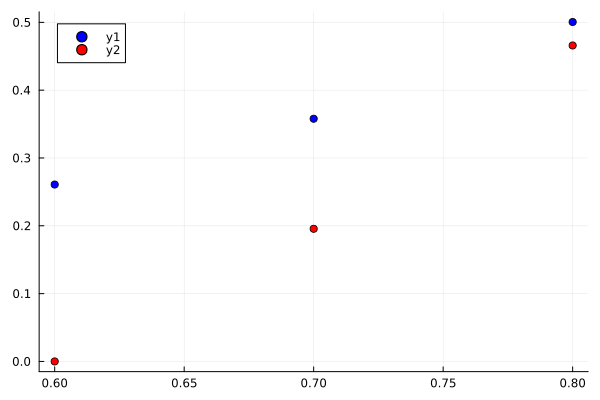

([-0.0, 0.19558155331343063, 0.46588263875377334], [0.26082105428198255, 0.3578574953111222, 0.5005047655758411])

In [45]:
plotBoundHolderreg(phi1,T1(0),0.6,0.1,3,n,N,m,M,nu,Nu,true)

## Examples of transformations

In [27]:
struct T
    image
    d
    maxd
    mind
    degree
end

In [28]:
T1(e)=T(x->2*x+e*sin(2*pi*x),x->2+2*pi*e*cos(2*pi*x),2+2*pi*e,2-2*pi*e,2)

T1 (generic function with 1 method)

## Examples of laws of reproduction

In [29]:
struct phi
    image
    logds
    exp
    maxexp
    maxdexp
    maxdx
end

In [30]:
phi1(l)=phi((x,s)->exp((s - 1) * exp(l + cos(2 * x * π))),(x,s)->log(exp(l + cos(2 * x * π)) * phi1(l).image(x, s)),x->exp(l+cos(2 * x * π)),exp(l+1),2*π*exp(l+1),2*π/exp(1))

phi1 (generic function with 1 method)

In [31]:
phi2(l)=phi((x,s)->exp((s - 1) * exp(l - cos(2 * x * π))),(x,s)->log(exp(l - cos(2 * x * π)) * phi2(l).image(x, s)),x->exp(l-cos(2 * x * π)),exp(l+1),2*π*exp(l+1),2*π/exp(1))

phi2 (generic function with 1 method)

## General settings

In [32]:
N = 14 # 2^N est le nb d'intervalles
n = 14 # le nb d'itérations de notre fonction majorante et minorante
m = 8
M = 8 # taille max des orbites périodiques

8

In [33]:
Nu=14
nu=8
Mu=8

8

## Main

In [40]:
e=0.1
"e doit etre inférieur à 1/(pi*2) soit environ 0.159"
l=0.6

l